In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/P3DCV/Diff-FMAPs/code/"
import sys
sys.path.insert(0, "/content/drive/MyDrive/P3DCV/Diff-FMAPs/code/")

/content/drive/MyDrive/P3DCV/Diff-FMAPs/code


In [3]:
!pip install joblib
!pip install plyfile
!pip install polyscope
!pip install scikit-learn
!pip install scipy
!pip install threadpoolctl
!pip install tqdm
!pip install typing-extensions
!pip install libigl
!pip install potpourri3d
!pip install robust_laplacian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.3/869.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.1/390.1 kB 6.4 MB/s eta 0:00:00


In [3]:
import igl
import numpy as np
import os
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
from Diffusionnet_MPIFAUST_dataset import DiffusionnetFaustDataset2
from model_diffusionnet import FunctionalMapCorrespondenceWithDiffusionNetFeatures

from tqdm import tqdm

import torch
import matplotlib.pyplot as plt


In [4]:
dtype = torch.float32
# model
input_features = 'xyz' # one of ['xyz', 'hks']
k_eig = 128

# functional maps settings
n_fmap = 30 # number of eigenvectors used within functional maps
n_feat = 100 # dimension of features computed by DiffusionNet extractor
lambda_param = 1e-3 # functional map block regularization parameter

# training settings
train = True
n_epoch = 50
lr = 5e-4
decay_every = 9999
decay_rate = 0.1
augment_random_rotate = (input_features == 'xyz')

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epoch = 50
lr = 5e-4
decay_every = 9999
decay_rate = 0.1
root_dir = "/content/drive/MyDrive/P3DCV/data/"
op_cache_dir = os.path.join(root_dir, "op_cache")
#defining train and test set
train_set = DiffusionnetFaustDataset2(root_dir, name="MPI-FAUST", train=True, k_eig=k_eig, use_cache=True, op_cache_dir=op_cache_dir)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_set = DiffusionnetFaustDataset2(root_dir, name="MPI-FAUST", train=False, k_eig=k_eig, use_cache=True, op_cache_dir=op_cache_dir)
test_loader = DataLoader(test_set, batch_size=2, shuffle=True)
'''
IMPORTANT: Model Saving
'''
model_save_dir = os.path.join(root_dir, "models", "diffusionet")
if not os.path.exists(model_save_dir):
  os.makedirs(model_save_dir, exist_ok=True)

length of dataset: 3160
using dataset cache path: /content/drive/MyDrive/P3DCV/data/MPI-FAUST/cache/train.pt
  --> loading dataset from cache
length of dataset: 190
using dataset cache path: /content/drive/MyDrive/P3DCV/data/MPI-FAUST/cache/test.pt
  --> loading dataset from cache


In [ ]:
for i, data in enumerate(train_loader):
  shape1, shape2 = data

  #verts1, faces1, frames1, mass1, L1, evals1, evecs1, gradX1, gradY1, hks1 = shape1
  #verts2, faces2, frames2, mass2, L2, evals2, evecs2, gradX2, gradY2, hks2 = shape2
  *shape1, name1, basis1 = shape1
  *shape2, name2, basis2 = shape2
  print("basis1 shape", basis1.shape)
  print("basis2 shape", basis2.shape)

In [6]:
model = FunctionalMapCorrespondenceWithDiffusionNetFeatures(
                        n_feat= n_feat,#multi-head: 2*n_feat, single-head: n_feat
                        input_features=input_features,
                        lambda_param=lambda_param
                        )


model = model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
l1_loss = torch.nn.L1Loss(reduction='mean')

In [ ]:
#single head training loop

epoch_train_loss = []
epoch_val_loss = []
for epoch in range(n_epoch):
    train_losses = []
    train_elastic_losses = []
    train_total_losses = []
    val_losses = []
    val_elastic_losses = []
    val_total_losses = []
    faust_losses = []
    #metrics = []
    # Training single Epoch
    model.train()
    for i, data in enumerate(train_loader):
        shapeA, shapeB = data
        *shapeA, nameA, gtbasisA = shapeA
        *shapeB, nameB, gtbasisB = shapeB
        shapeA, shapeB = [x.to(device) for x in shapeA], [x.to(device) for x in shapeB]
        gtbasisA, gtbasisB = gtbasisA.to(device).to(torch.float32), gtbasisB.to(device).to(torch.float32)
        optim.zero_grad()

        # Obtaining predicted basis
        basisA, basisB = model(shapeA, shapeB)

        # Computing optimal transformation
        pseudo_inv_A = torch.pinverse(basisA)
        C_opt = torch.matmul(pseudo_inv_A, basisB)
        opt_A = torch.matmul(basisA, C_opt)

        # SoftMap
        dist_matrix = torch.cdist(opt_A, basisB)
        s_max = torch.nn.Softmax(dim=1)
        s_max_matrix = s_max(-dist_matrix)

        # Basis Loss
        vertsB = shapeB[0] #get vertsB out
        eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))

        # Elastic Loss
        #elastic_loss = l1_loss(basisA, gtbasisA) + l1_loss(basisB, gtbasisB)
        l1_norm = 0.4 * torch.abs(basisA).mean() + 0.4 * torch.abs(basisB).mean()
        #metric = torch.mean(torch.square(s_max_matrix - torch.identity(s_max_matrix.shape[0]))) # measuring how well we are approximating the ground-truth correspondence
        # Back Prop
        #total_loss = eucl_loss +  elastic_loss
        total_loss = eucl_loss + l1_norm
        total_loss.backward()
        #eucl_loss.backward()
        optim.step()
        train_losses.append(eucl_loss.detach().item())
        train_elastic_losses.append(l1_norm.detach().item())
        #train_elastic_losses.append(elastic_loss.detach().item())
        train_total_losses.append(total_loss.detach().item())
        #metrics.append(metric.detach().item())

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(test_loader):
          shapeA, shapeB = data
          *shapeA, nameA, gtbasisA = shapeA
          *shapeB, nameB, gtbasisB = shapeB
          shapeA, shapeB = [x.to(device) for x in shapeA], [x.to(device) for x in shapeB]
          gtbasisA, gtbasisB = gtbasisA.to(device).to(torch.float32), gtbasisB.to(device).to(torch.float32)

          basisA, basisB = model(shapeA, shapeB)

          pseudo_inv_A = torch.pinverse(basisA)
          C_opt = torch.matmul(pseudo_inv_A, basisB)
          opt_A = torch.matmul(basisA, C_opt)
          # SoftMap
          dist_matrix = torch.cdist(opt_A, basisB)
          s_max = torch.nn.Softmax(dim=1)
          s_max_matrix = s_max(-dist_matrix)

          # Basis Loss
          vertsB = shapeB[0]
          val_eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))
          #val_elastic_loss = l1_loss(basisA, gtbasisA) + l1_loss(basisB, gtbasisB)
          val_l1_norm = 0.4 * torch.abs(basisA).mean() + 0.4 * torch.abs(basisB).mean()
          val_total_loss = val_eucl_loss + val_l1_norm
          #val_total_loss = val_eucl_loss + val_elastic_loss
          val_losses.append(val_eucl_loss.detach().item())
          #val_elastic_losses.append(val_elastic_loss.detach().item())
          val_elastic_losses.append(val_l1_norm.detach().item())
          val_total_losses.append(val_total_loss.detach().item())

    ave_train_loss = sum(train_losses) / len(train_losses)
    ave_train_elastic_loss = sum(train_elastic_losses) / len(train_elastic_losses)
    ave_train_total_loss = sum(train_total_losses) / len(train_total_losses)
    ave_val_loss = sum(val_losses) / len(val_losses)
    ave_val_elastic_loss = sum(val_elastic_losses) / len(val_elastic_losses)
    ave_val_total_loss = sum(val_total_losses) / len(val_total_losses)
    #ave_metric = sum(metrics) / len(metrics)
    print()
    print(f"training eucl loss for epoch{epoch}:", ave_train_loss)
    print(f"training elastic loss for epoch{epoch}:", ave_train_elastic_loss)
    print(f"training total loss for epoch{epoch}:", ave_train_total_loss)
    print(f"validation eucl loss for epoch{epoch}:", ave_val_loss)
    print(f"validation elastic loss for epoch{epoch}:", ave_val_elastic_loss)
    print(f"validation total loss for epoch{epoch}:", ave_val_total_loss)
    #print(f"training metric for epoch{epoch}:", ave_metric)
    torch.save(model.state_dict(), os.path.join(model_save_dir, f"train6_k_{n_feat}_epoch_{epoch}"))
    epoch_train_loss.append(ave_train_loss)
    epoch_val_loss.append(ave_val_loss)
np.save(f"/content/drive/MyDrive/P3DCV/losses/train/diffusionnet6_k_{n_feat}.npy", np.array(epoch_train_loss))
np.save(f"/content/drive/MyDrive/P3DCV/losses/val/diffusionnet6_k_{n_feat}.npy", np.array(epoch_val_loss))


training eucl loss for epoch0: 432.71260932246344
training elastic loss for epoch0: 0.5443553938895841
training total loss for epoch0: 433.2569652509086
validation eucl loss for epoch0: 39.99564309371145
validation elastic loss for epoch0: 0.7213466801141438
validation total loss for epoch0: 40.716989617598685

training eucl loss for epoch1: 91.27370835316331
training elastic loss for epoch1: 0.790992936303344
training total loss for epoch1: 92.06470137970356
validation eucl loss for epoch1: 41.930756498637955
validation elastic loss for epoch1: 0.8082053843297456
validation total loss for epoch1: 42.73896175183748

training eucl loss for epoch2: 72.43614970340005
training elastic loss for epoch2: 0.8429390335384803
training total loss for epoch2: 73.27908869876137
validation eucl loss for epoch2: 35.88742270218699
validation elastic loss for epoch2: 0.8408472525446038
validation total loss for epoch2: 36.72827003880551

training eucl loss for epoch3: 62.57115431194064
training elasti

In [ ]:
# Multi-head Training Loop
epoch_train_loss = []
epoch_val_loss = []
for epoch in range(n_epoch):
    train_losses = []
    train_elastic_losses = []
    train_total_losses = []
    val_losses = []
    val_elastic_losses = []
    val_total_losses = []
    faust_losses = []
    #metrics = []
    # Training single Epoch
    model.train()
    for i, data in enumerate(train_loader):
        shapeA, shapeB = data
        *shapeA, nameA, gtbasisA = shapeA
        *shapeB, nameB, gtbasisB = shapeB
        shapeA, shapeB = [x.to(device) for x in shapeA], [x.to(device) for x in shapeB]
        gtbasisA, gtbasisB = gtbasisA.to(device).to(torch.float32), gtbasisB.to(device).to(torch.float32)
        optim.zero_grad()

        # Obtaining predicted basis
        #basisA, basisB = model(shapeA, shapeB)
        predA, predB = model(shapeA, shapeB)
        basisA, basisB = predA[:, :, :n_feat], predB[:, :, :n_feat]
        elasticA, elasticB = predA[:, :, n_feat:], predB[:, :, n_feat:]

        # Computing optimal transformation
        pseudo_inv_A = torch.pinverse(basisA)
        C_opt = torch.matmul(pseudo_inv_A, basisB)
        opt_A = torch.matmul(basisA, C_opt)

        # SoftMap
        dist_matrix = torch.cdist(opt_A, basisB)
        s_max = torch.nn.Softmax(dim=1)
        s_max_matrix = s_max(-dist_matrix)

        # Basis Loss
        vertsB = shapeB[0] #get vertsB out
        eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))

        # Elastic Loss
        elastic_loss = l1_loss(elasticA, gtbasisA) + l1_loss(elasticB, gtbasisB)
        #metric = torch.mean(torch.square(s_max_matrix - torch.identity(s_max_matrix.shape[0]))) # measuring how well we are approximating the ground-truth correspondence
        # Back Prop
        total_loss = eucl_loss + 0.2 * elastic_loss
        total_loss.backward()
        #eucl_loss.backward()
        optim.step()
        train_losses.append(eucl_loss.detach().item())
        train_elastic_losses.append(elastic_loss.detach().item())
        train_total_losses.append(total_loss.detach().item())
        #metrics.append(metric.detach().item())

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(test_loader):
          shapeA, shapeB = data
          *shapeA, nameA, gtbasisA = shapeA
          *shapeB, nameB, gtbasisB = shapeB
          shapeA, shapeB = [x.to(device) for x in shapeA], [x.to(device) for x in shapeB]
          gtbasisA, gtbasisB = gtbasisA.to(device).to(torch.float32), gtbasisB.to(device).to(torch.float32)

          #basisA, basisB = model(shapeA, shapeB)
          predA, predB = model(shapeA, shapeB)
          basisA, basisB = predA[:, :, :n_feat], predB[:, :, :n_feat]
          elasticA, elasticB = predA[:, :, n_feat:], predB[:, :, n_feat:]

          pseudo_inv_A = torch.pinverse(basisA)
          C_opt = torch.matmul(pseudo_inv_A, basisB)
          opt_A = torch.matmul(basisA, C_opt)
          # SoftMap
          dist_matrix = torch.cdist(opt_A, basisB)
          s_max = torch.nn.Softmax(dim=1)
          s_max_matrix = s_max(-dist_matrix)

          # Basis Loss
          vertsB = shapeB[0]
          val_eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))
          val_elastic_loss = l1_loss(elasticA, gtbasisA) + l1_loss(elasticB, gtbasisB)
          val_total_loss = val_eucl_loss + 0.2 * val_elastic_loss
          val_losses.append(val_eucl_loss.detach().item())
          val_elastic_losses.append(val_elastic_loss.detach().item())
          val_total_losses.append(val_total_loss.detach().item())

    ave_train_loss = sum(train_losses) / len(train_losses)
    ave_train_elastic_loss = sum(train_elastic_losses) / len(train_elastic_losses)
    ave_train_total_loss = sum(train_total_losses) / len(train_total_losses)
    ave_val_loss = sum(val_losses) / len(val_losses)
    ave_val_elastic_loss = sum(val_elastic_losses) / len(val_elastic_losses)
    ave_val_total_loss = sum(val_total_losses) / len(val_total_losses)
    #ave_metric = sum(metrics) / len(metrics)
    print()
    print(f"training eucl loss for epoch{epoch}:", ave_train_loss)
    print(f"training elastic loss for epoch{epoch}:", ave_train_elastic_loss)
    print(f"training total loss for epoch{epoch}:", ave_train_total_loss)
    print(f"validation eucl loss for epoch{epoch}:", ave_val_loss)
    print(f"validation elastic loss for epoch{epoch}:", ave_val_elastic_loss)
    print(f"validation total loss for epoch{epoch}:", ave_val_total_loss)
    #print(f"training metric for epoch{epoch}:", ave_metric)
    torch.save(model.state_dict(), os.path.join(model_save_dir, f"train3_k_{n_feat}_epoch_{epoch}"))
    epoch_train_loss.append(ave_train_loss)
    epoch_val_loss.append(ave_val_loss)
np.save(f"/content/drive/MyDrive/P3DCV/losses/train/diffusionnet_k_{n_feat}.npy", np.array(epoch_train_loss))
np.save(f"/content/drive/MyDrive/P3DCV/losses/val/difffmap_k_{n_feat}.npy", np.array(epoch_val_loss))




training eucl loss for epoch0: 418.37023935438714
training elastic loss for epoch0: 0.8814719086960902
training total loss for epoch0: 418.5465338791473
validation eucl loss for epoch0: 40.53102505332545
validation elastic loss for epoch0: 0.8309022859523171
validation total loss for epoch0: 40.69720555355674

training eucl loss for epoch1: 89.80323909324936
training elastic loss for epoch1: 0.8643974907790558
training total loss for epoch1: 89.97611844992336
validation eucl loss for epoch1: 46.2820611652575
validation elastic loss for epoch1: 0.8302119725628903
validation total loss for epoch1: 46.448103693911904

training eucl loss for epoch2: 70.85475842439676
training elastic loss for epoch2: 0.8617582156688353
training total loss for epoch2: 71.02711002977588
validation eucl loss for epoch2: 47.74801370721114
validation elastic loss for epoch2: 0.8298683831566258
validation total loss for epoch2: 47.91398712961297

training eucl loss for epoch3: 60.70216915275477
training elastic

KeyboardInterrupt: ignored

**visualization train and loss curves**

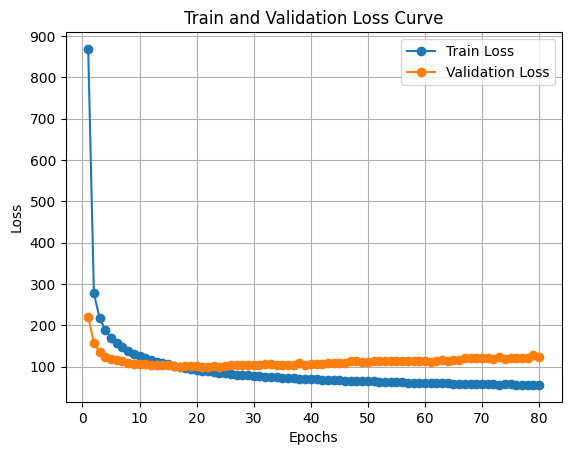

In [ ]:
train_loss_array = np.load(f"/content/drive/MyDrive/P3DCV/losses/train/difffmap_1.76573.npy")
val_loss_array = np.load(f"/content/drive/MyDrive/P3DCV/losses/val/difffmap_1.76573.npy")
epochs = np.arange(1, len(train_loss_array) + 1)

plt.plot(epochs, train_loss_array, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_array, label='Validation Loss', marker='o')

plt.title('Train and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#test loops
for epoch in range(n_epoch):
    train_losses = []
    eval_losses = []
    faust_losses = []
    metrics = []
    # Training single Epoch
    for i, data in enumerate(train_loader):
        vertsA, vertsB = data
        batch = vertsA.shape[0]
        vertsA = vertsA.to(device).to(torch.float32)
        vertsB = vertsB.to(device).to(torch.float32)
        cat_verts = torch.cat([vertsA.transpose(1,2), vertsB.transpose(1,2)], dim=0)
        optim.zero_grad()
        basisNet = basisNet.train()

        # Obtaining predicted basis
        cat_preds, _, _ = basisNet(cat_verts)#cat_pred.shape (B, n_points, k)

        basisA = cat_preds[:batch, :, :]
        basisB = cat_preds[batch:, :, :]
        # Computing optimal transformation
        pseudo_inv_A = torch.pinverse(basisA)
        C_opt = torch.matmul(pseudo_inv_A, basisB)
        opt_A = torch.matmul(basisA, C_opt)

        # SoftMap
        dist_matrix = torch.cdist(opt_A, basisB)
        s_max = torch.nn.Softmax(dim=1)
        s_max_matrix = s_max(-dist_matrix)

        # Basis Loss
        eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, vertsB) - vertsB))

        #metric = torch.mean(torch.square(s_max_matrix - torch.identity(s_max_matrix.shape[0]))) # measuring how well we are approximating the ground-truth correspondence
        # Back Prop
        eucl_loss.backward()
        optim.step()
        train_losses.append(eucl_loss.detach().item())
        #metrics.append(metric.detach().item())
    ave_train_loss = sum(train_losses) / len(train_losses)
    #ave_metric = sum(metrics) / len(metrics)
    print(f"training loss for epoch{epoch}:", ave_train_loss)
    #print(f"training metric for epoch{epoch}:", ave_metric)
    torch.save(basisNet.state_dict(), f"/content/drive/MyDrive/P3DCV/models/difffmap_resampled_epoch_{epoch}.pt")



In [ ]:
'''

    # Validation
    with torch.no_grad():
        eval_loss = 0
        for data in tqdm(dataset_test, 0):
            points = data[0]
            points = points.transpose(2, 1)
            points = points.cuda()
            basisNet = basisNet.eval()
            pred, _, _ = basisNet(points)
            basis_A = pred[1:,:,:]; basis_B = pred[:-1,:,:]
            pc_A = points[1:,:,:]; pc_B = points[:-1,:,:]

            pseudo_inv_A = torch.pinverse(basis_A)
            C_opt = torch.matmul(pseudo_inv_A, basis_B)
            opt_A = torch.matmul(basis_A, C_opt)

            dist_matrix = torch.cdist(opt_A, basis_B)
            s_max = torch.nn.Softmax(dim=1)
            s_max_matrix = s_max(-dist_matrix)
            eucl_loss = torch.sum(torch.square(torch.matmul(s_max_matrix, torch.transpose(pc_B,1,2)) - torch.transpose(pc_B,1,2)))
            eval_loss +=   eucl_loss.item()

        print('EPOCH ' + str(epoch) + ' - eva_loss: ' + str(eval_loss))

        # Saving if best model so far
        if eval_loss <  best_eval_loss:
            print('save model')
            best_eval_loss = eval_loss
            torch.save(basisNet.state_dict(), '%s/basis_model_best.pth' % (outf))

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)

        # Logging losses
        np.save(outf+'/train_losses_basis.npy',train_losses)
        np.save(outf+'/eval_losses_basis.npy',eval_losses)
'''